# Importing the relevant libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing

### Importing the Database

In [5]:
raw_data = pd.read_csv('ml_datasource.csv')
print(raw_data.columns)
raw_data.head(5)

Index(['student_country', 'days_on_platform', 'minutes_watched',
       'courses_started', 'practice_exams_started', 'practice_exams_passed',
       'minutes_spent_on_exams', 'purchased'],
      dtype='object')


,student_country,days_on_platform,minutes_watched,courses_started,practice_exams_started,practice_exams_passed,minutes_spent_on_exams,purchased
0,US,288,358.1,1,2,2,15.81,0
1,SG,260,1.7,1,1,0,16.00,0
2,TR,260,22.4,1,1,0,0.93,0
3,KE,259,18.8,1,1,1,14.63,0
4,IN,259,118.0,2,2,1,16.48,0


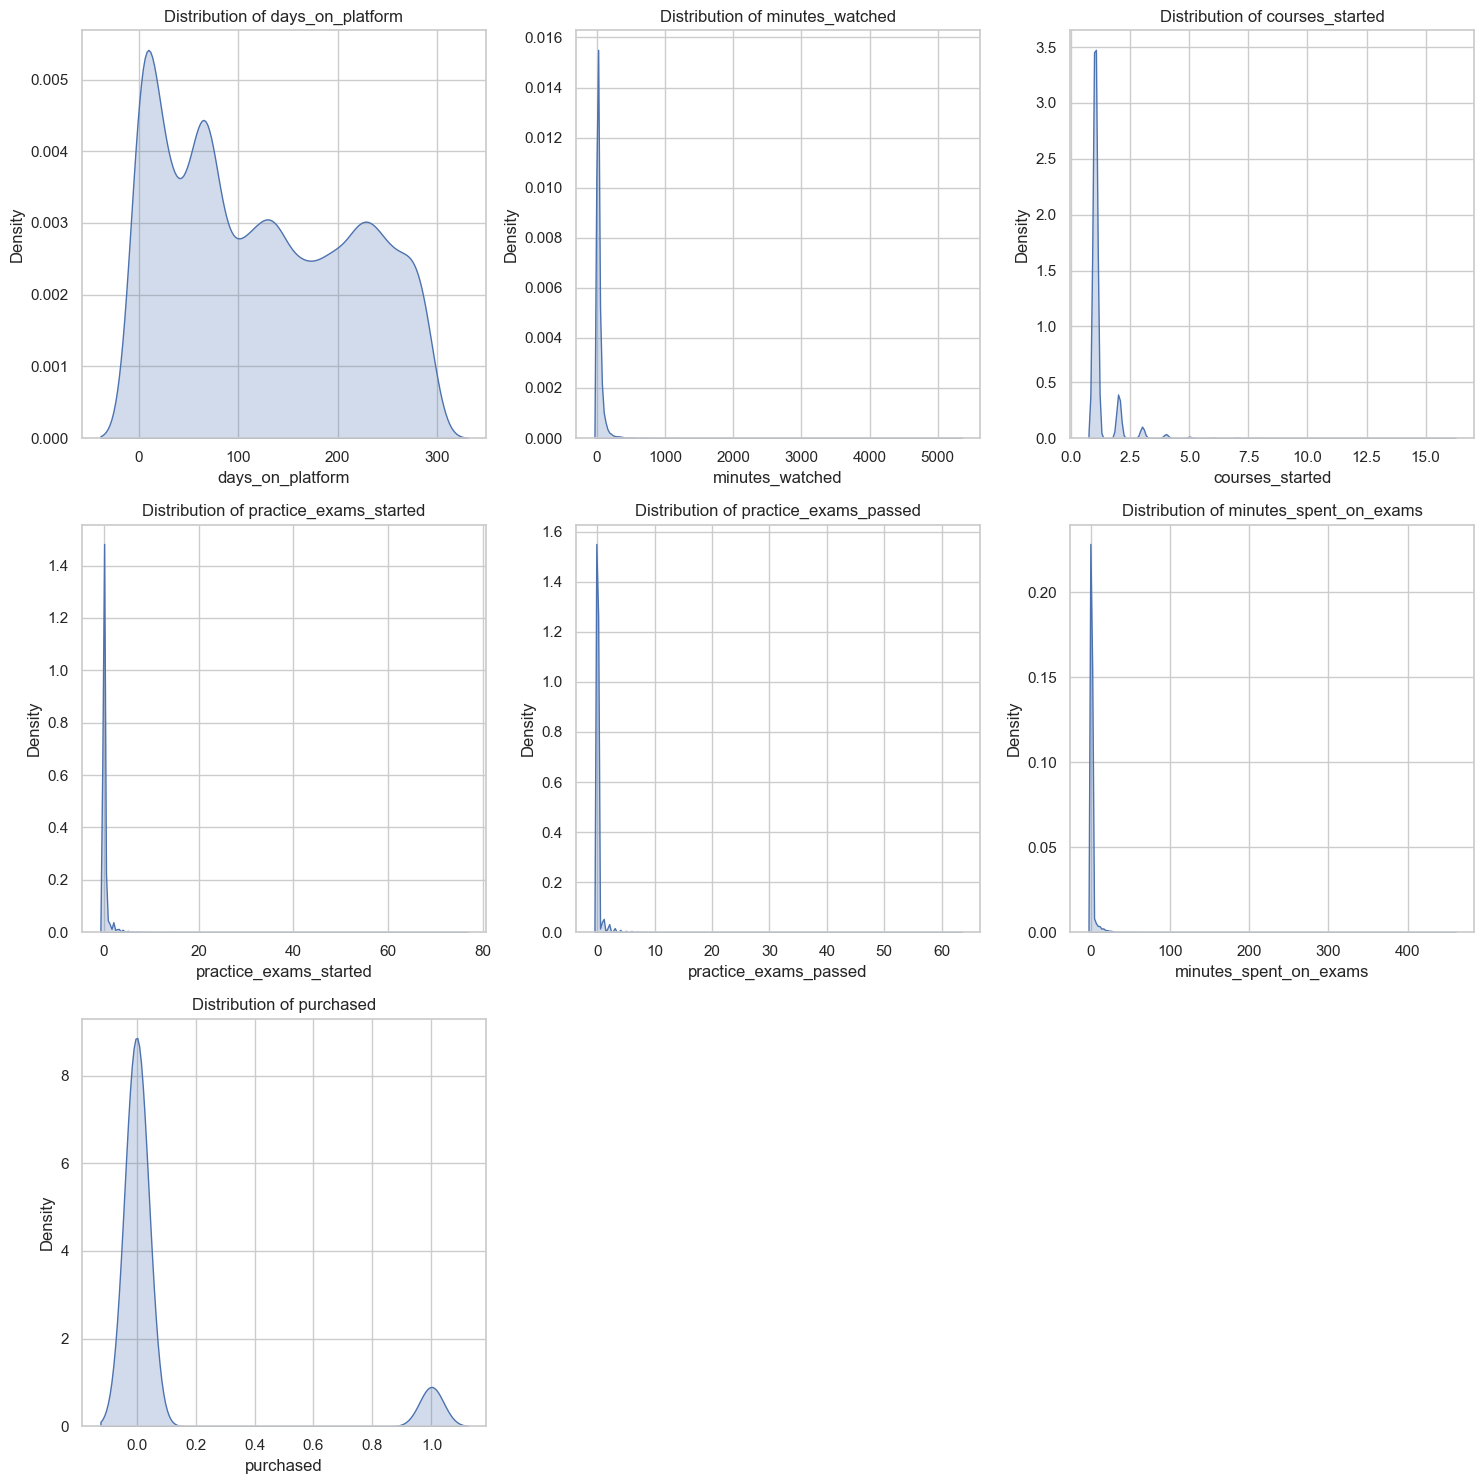

In [11]:
data = raw_data.copy()
# Set Seaborn theme
sns.set(style="whitegrid")

# Define numerical features
numerical_features = [
    "days_on_platform", "minutes_watched", "courses_started",
    "practice_exams_started", "practice_exams_passed",
    "minutes_spent_on_exams", "purchased"
]

# Determine grid size dynamically
num_features = len(numerical_features)
rows = (num_features // 3) + (num_features % 3 > 0)  # Number of rows (ceil division)
cols = min(3, num_features)  # Limit to 3 columns per row

# Create subplots dynamically
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))
axes = axes.flatten()  # Flatten to 1D array for easier indexing

# Plot KDE distributions
for i, feature in enumerate(numerical_features):
    sns.kdeplot(data[feature], ax=axes[i], fill=True)
    axes[i].set_title(f"Distribution of {feature}")

# Hide any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Removing Outliers

In [12]:
# Step 1: Filter out outliers
data_no_outliers = data[
    (data["minutes_watched"] <= 1000) &
    (data["courses_started"] <= 10) &
    (data["practice_exams_started"] <= 10) &
    (data["minutes_spent_on_exams"] <= 40)
]

# Step 2: Display the shape of the data before and after filtering
print(f"Original data shape: {data.shape}")
print(f"Filtered data shape: {data_no_outliers.shape}")



Original data shape: (17761, 8)
Filtered data shape: (17626, 8)


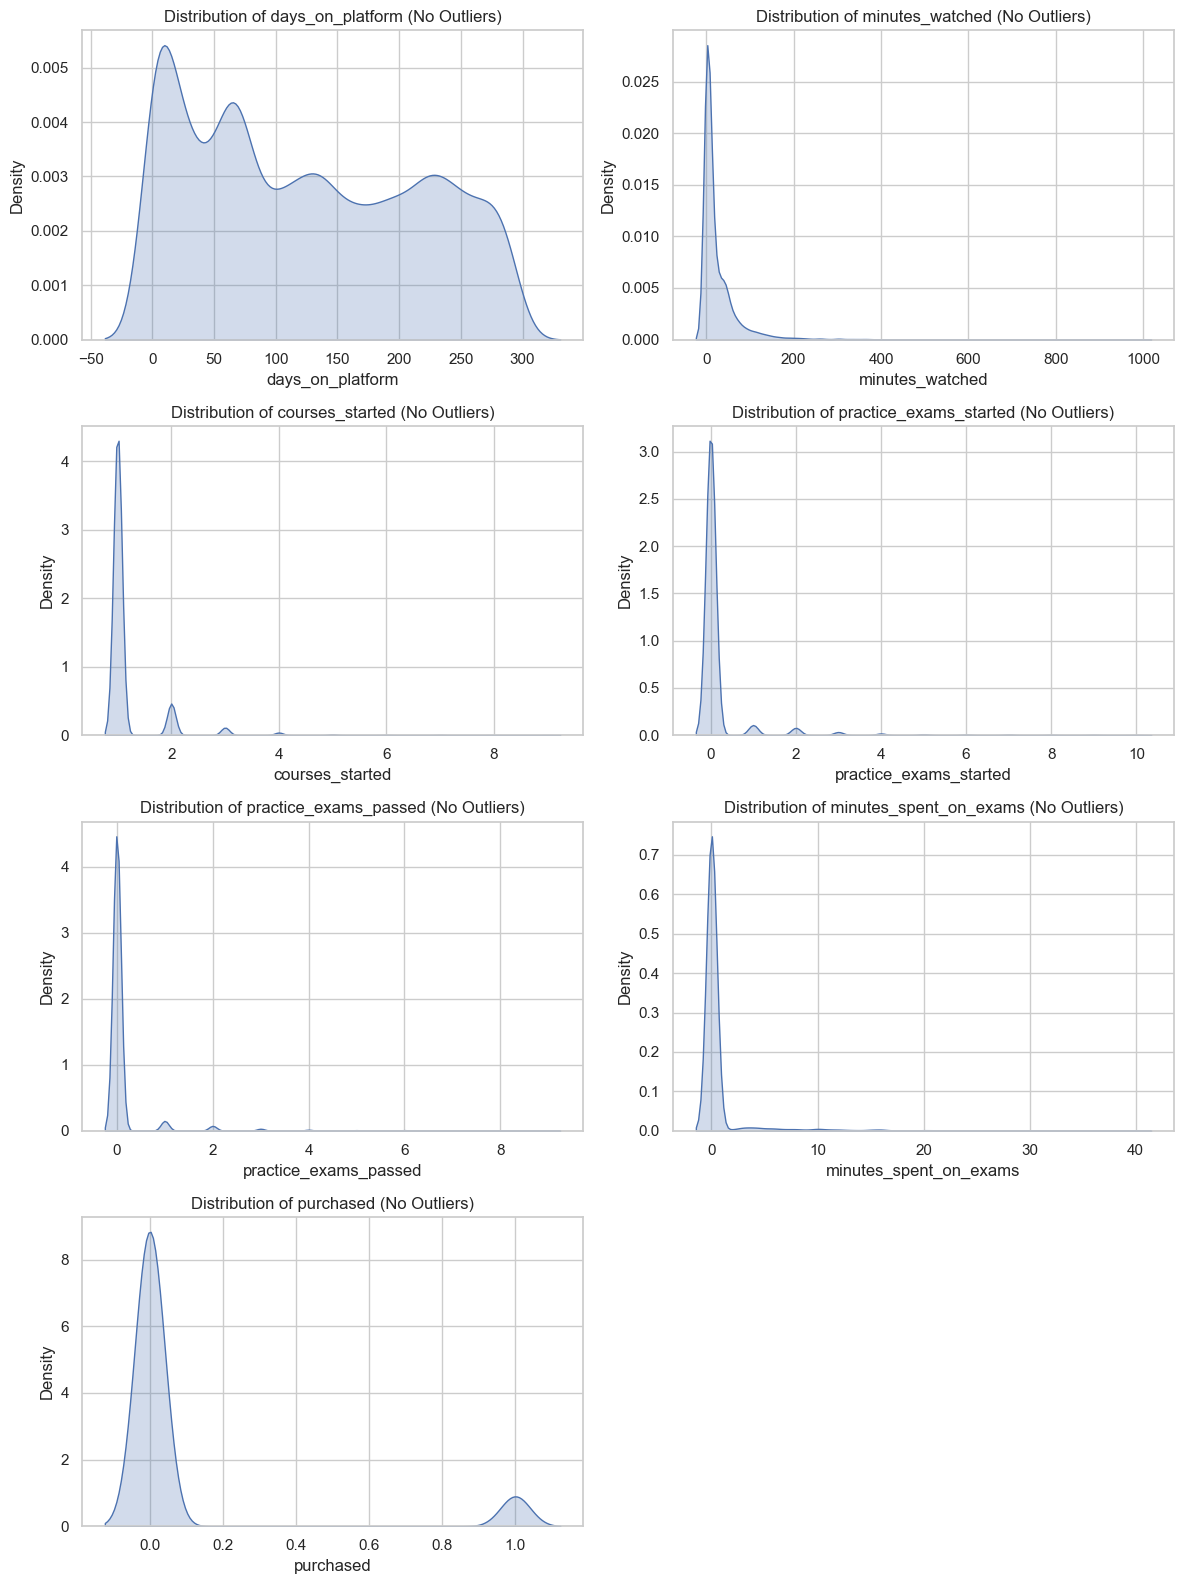

In [14]:
# Step 1: Get the number of features
num_features = len(numerical_features)

# Step 2: Dynamically determine rows & columns
rows = (num_features // 2) + (num_features % 2 > 0)  # Ensures enough rows
cols = min(2, num_features)  # Max 2 columns

# Step 3: Create subplots dynamically
fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 4))  # Adjust height dynamically
axes = axes.flatten()  # Convert to 1D array for easier indexing

# Step 4: Plot KDE distributions for the filtered dataset
for i, feature in enumerate(numerical_features):
    if feature in data_no_outliers.columns:  # Avoid KeyError
        sns.kdeplot(data=data_no_outliers[feature], ax=axes[i], fill=True)
        axes[i].set_title(f"Distribution of {feature} (No Outliers)")
    else:
        print(f"Warning: '{feature}' not found in dataset.")

# Step 5: Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### Checking for Multicollinearity

### Dealing with NaN Values

### Splitting the Data

### Encoding the Data

# Creating a Logistic Regression Model

# Creating a K-Nearest Neighbors Model

# Creating a Support Vector Machines Model

# Creating a Decision Trees Model

# Creating a Random Forests Model